## Setup

The cell below downloads the code from Github and install necessary dependencies.

In [1]:
# !cd .. && pip install -e "."
# !pip install matplotlib

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"

import json
import os
import time
from typing import Any

import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import ml_collections
import numpy as np
from absl import logging
from matplotlib.colors import ListedColormap

import sys
sys.path.append("/root/projects/deeprte")

from deeprte.data import pipeline
from deeprte.model import model
from deeprte.model.utils import flat_params_to_haiku

logging.set_verbosity(logging.INFO)

jax.local_devices()

[cuda(id=0)]

### Utility functions

In [2]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target) ** 2) / np.mean(target**2))


def get_normalization_ratio(psi_range, boundary_range):
    psi_range = float(psi_range.split(" ")[-1])
    boundary_range = float(boundary_range.split(" ")[-1])
    return psi_range / boundary_range


def jnp_to_np(output: dict[str, Any]) -> dict[str, Any]:
    """Recursively changes jax arrays to numpy arrays."""
    for k, v in output.items():
        if isinstance(v, dict):
            output[k] = jnp_to_np(v)
        elif isinstance(v, jnp.ndarray):
            output[k] = np.array(v)
    return output


def plot_phi(r, phi_pre, phi_label):
    fig, _axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    fig.subplots_adjust(hspace=0.3)
    axs = _axs.flatten()

    viridis = matplotlib.colormaps["viridis"](np.linspace(0, 1.2, 128))
    cs_1 = axs[0].contourf(
        r[..., 0], r[..., 1], phi_label, cmap=ListedColormap(viridis)
    )
    axs[0].set_title(r"Exact $f(x,v)$", fontsize=20)
    axs[0].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_1)
    cbar.ax.tick_params(labelsize=16)

    cs_2 = axs[1].contourf(r[..., 0], r[..., 1], phi_pre, cmap=ListedColormap(viridis))
    axs[1].set_title(r"Predict $f(x,v)$", fontsize=20)
    axs[1].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_2)
    cbar.ax.tick_params(labelsize=16)

    cs_3 = axs[2].contourf(
        r[..., 0],
        r[..., 1],
        abs(phi_pre - phi_label),
        cmap=ListedColormap(viridis),
    )
    axs[2].set_title(r"Absolute error", fontsize=20)
    axs[2].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_3)
    cbar.ax.tick_params(labelsize=16)

    plt.tight_layout()

## Load Dataset

In [7]:
# Path to the dataset
DATA_DIR = "/root/projects/deeprte/data/test/bc1-g0.1"
DATA_NAME = ["bc1-g0.1_downsampling.mat"]

data_pipeline = pipeline.DataPipeline(DATA_DIR, DATA_NAME)
raw_feature_dict = data_pipeline.process()
num_examples = raw_feature_dict["shape"]["num_examples"]

del data_pipeline

jax.tree_map(lambda x: x.shape, raw_feature_dict["functions"])

{'boundary': (100, 160, 12),
 'boundary_scattering_kernel': (100, 160, 12, 24),
 'psi_label': (100, 40, 40, 24),
 'scattering_kernel': (100, 40, 40, 24, 24),
 'self_scattering_kernel': (100, 24, 24),
 'sigma': (100, 20, 20, 2)}

## Import Pre-trained model

#### Load model config

In [8]:
MODEL_DIR = "/root/projects/deeprte/data/ckpts/g0.1-sigma_a3-sigma_t6_2023-05-14T18:50:04/models/latest/step_500000_2023-05-23T12:05:36"

model_config_path = os.path.join(MODEL_DIR, "model.json")
with open(model_config_path) as f:
    str = f.read()
    model_config = ml_collections.ConfigDict(json.loads(str))

model_config

data:
  is_normalization: true
  normalization_dict:
    boundary_min: '0.0'
    boundary_range: '0.19474658'
    psi_min: '3.8484396e-10'
    psi_range: '0.14552617'
global_config:
  bc_loss_weights: 1.0
  deterministic: true
  loss_weights: 5.0
  subcollocation_size: 128
  w_init: glorot_uniform
green_function:
  attenuation:
    attention:
      key_chunk_size: 128
      key_dim: 32
      num_head: 2
      output_dim: 2
      value_dim: null
    latent_dim: 128
    num_layer: 4
    output_dim: 16
  scattering:
    latent_dim: 16
    num_layer: 2

#### Load model parameters

In [9]:
params_path = os.path.join(MODEL_DIR, "params.npz")

np_params = np.load(params_path, allow_pickle=True)
params = flat_params_to_haiku(np_params)

jax.tree_map(lambda x: x.shape, params)

2024-03-06 05:43:44.745098: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


{'deeprte/green_function/attenuation/attention/key': {'b': (64,),
  'w': (2, 64)},
 'deeprte/green_function/attenuation/attention/output_projection': {'b': (2,),
  'w': (64, 2)},
 'deeprte/green_function/attenuation/attention/query': {'b': (64,),
  'w': (4, 64)},
 'deeprte/green_function/attenuation/attention/value': {'b': (64,),
  'w': (2, 64)},
 'deeprte/green_function/attenuation/attenuation_linear': {'b': (128,),
  'w': (10, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_1': {'b': (128,),
  'w': (128, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_2': {'b': (128,),
  'w': (128, 128)},
 'deeprte/green_function/attenuation/output_projection': {'b': (16,),
  'w': (128, 16)},
 'deeprte/green_function/output_projection': {'w': (16, 1)},
 'deeprte/green_function/scattering_module/__layer_stack_no_per_layer/layer_norm': {'offset': (2,
   16),
  'scale': (2, 16)},
 'deeprte/green_function/scattering_module/__layer_stack_no_per_layer/scattering_layer/linear':

In [10]:
import haiku as hk

hk.data_structures.tree_size(params)

37954

#### Construct model runner

In [8]:
model_runner = model.RunModel(model_config, params, multi_devices=False)


def get_normalization_ratio(psi_range, boundary_range):
    psi_range = float(psi_range.split(" ")[-1])
    boundary_range = float(boundary_range.split(" ")[-1])
    return psi_range / boundary_range


if model_config.data.is_normalization:
    normalization_dict = model_config.data.normalization_dict
    normalization_ratio = get_normalization_ratio(
        normalization_dict["psi_range"],
        normalization_dict["boundary_range"],
    )
else:
    normalization_ratio = None

## Predict and Evaluate

#### Predict and Evaluate i-th example in the dataset

In [9]:
# i = 1
i = np.random.randint(100)

#### Run prediction

In [10]:
logging.info("Predicting example %d/%d", i + 1, num_examples)

random_seed = 1
benchmark = True

feature_dict = {
    "functions": jax.tree_map(lambda x: x[i : i + 1], raw_feature_dict["functions"]),
    "grid": raw_feature_dict["grid"],
    "shape": raw_feature_dict["shape"],
}

# Run the model.
logging.info("Running model...")
processed_feature_dict = model_runner.process_features(feature_dict)
t_0 = time.time()
prediction_result = model_runner.predict(
    processed_feature_dict, random_seed=random_seed
)
t_diff = time.time() - t_0
logging.info(
    "Total JAX model predict time "
    "(includes compilation time, see --benchmark): %.1fs",
    t_diff,
)

if benchmark:
    t_0 = time.time()
    model_runner.predict(processed_feature_dict, random_seed=random_seed)
    t_diff = time.time() - t_0
    logging.info(
        "Total JAX model predict time " "(excludes compilation time): %.1fs",
        t_diff,
    )

psi_shape = feature_dict["functions"]["psi_label"].shape
t_0 = time.time()
predicted_psi = (
    prediction_result["predicted_psi"]
    .reshape(1, -1)  # reshape multi_devices to single device
    .reshape(psi_shape)
)
if normalization_ratio:
    predicted_psi = predicted_psi * normalization_ratio

predicted_phi = jnp.sum(
    predicted_psi * feature_dict["grid"]["velocity_weights"],
    axis=-1,
)
t_diff = time.time() - t_0

# Remove jax dependency from results.
np_prediction_result = jnp_to_np(dict(prediction_result))

# Compute metrics.
metrics = {}
psi_label = feature_dict["functions"]["psi_label"]
phi_label = np.sum(psi_label * feature_dict["grid"]["velocity_weights"], axis=-1)
psi_rmse = rmse(predicted_psi, psi_label)
phi_rmse = rmse(predicted_phi, phi_label)
logging.info("RMSE of psi: %f, RMSE of phi: %f\n", psi_rmse, phi_rmse)

INFO:absl:Predicting example 30/100
INFO:absl:Running model...


INFO:absl:Running predict with shape(feat) = {'boundary': (1, 1920), 'boundary_coords': (1, 1920, 4), 'boundary_weights': (1, 1920), 'phase_coords': (1, 38400, 4), 'position_coords': (1, 1600, 2), 'scattering_kernel': (1, 38400, 24), 'self_scattering_kernel': (1, 24, 24), 'sigma': (1, 1600, 2), 'velocity_coords': (1, 24, 2), 'velocity_weights': (1, 24)}
INFO:absl:Output shape was {'predicted_psi': (1, 38400)}
INFO:absl:Total JAX model predict time (includes compilation time, see --benchmark): 34.7s
INFO:absl:Running predict with shape(feat) = {'boundary': (1, 1920), 'boundary_coords': (1, 1920, 4), 'boundary_weights': (1, 1920), 'phase_coords': (1, 38400, 4), 'position_coords': (1, 1600, 2), 'scattering_kernel': (1, 38400, 24), 'self_scattering_kernel': (1, 24, 24), 'sigma': (1, 1600, 2), 'velocity_coords': (1, 24, 2), 'velocity_weights': (1, 24)}


### Visualize result

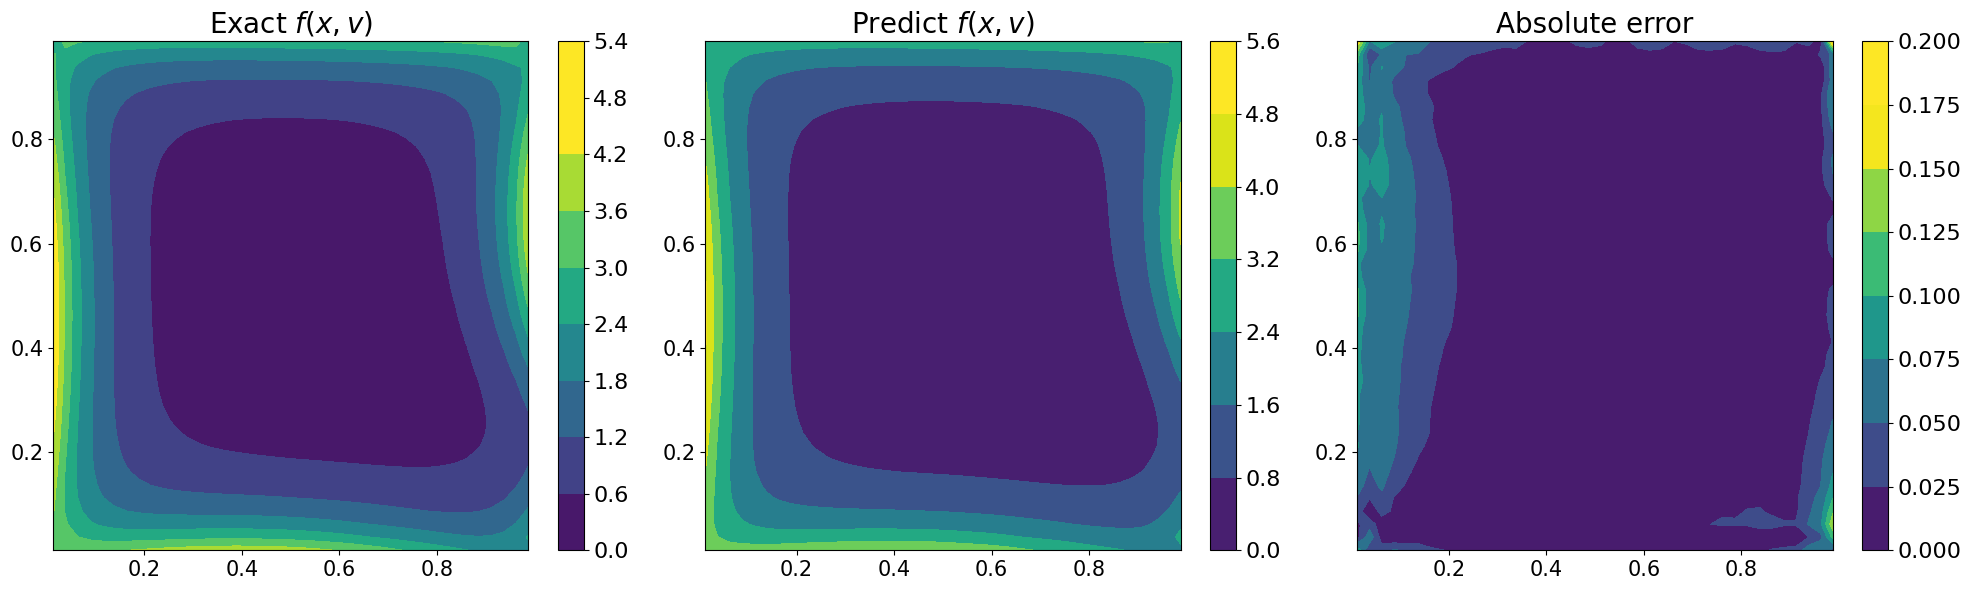

: 

In [ ]:
plot_phi(
    feature_dict["grid"]["position_coords"].reshape(*psi_shape[1:-1], -1),
    predicted_phi[0],
    phi_label[0],
)